In [1]:
! pip install tqdm

In [3]:
import polars as pl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import List, Tuple


In [4]:
PARQUET_PATH = "model_input.parquet"

NUM_ENTITIES = 23
COORDS       = ["x", "y"]
FEATS_PER_ENTITY = len(COORDS)          # 2
NUM_FEATS    = NUM_ENTITIES * FEATS_PER_ENTITY   # 46

SEQ_MIN_LEN  = 2        # need (t , t+1)
MAX_SEQ_LEN  = 100      # fixed pad length – change if you like

POSITIONAL_FEATURES = [f"{c}_{i}"
                  for i in range(1, NUM_ENTITIES + 1)
                  for c in COORDS]
INPUT_FEATURES = POSITIONAL_FEATURES.copy()  # Change as needeed
TARGET_FEATURES = POSITIONAL_FEATURES.copy()  # Change as needeed


In [5]:
df_test = pl.read_parquet(PARQUET_PATH)
df_test.describe()

statistic,gameId,playId,frameId,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,…,event_pass_forward,event_pass_outcome_caught,event_pass_outcome_incomplete,event_pass_outcome_interception,event_pass_outcome_touchdown,event_pass_shovel,event_pass_tipped,event_penalty_accepted,event_penalty_flag,event_play_action,event_play_submit,event_qb_kneel,event_qb_sack,event_qb_slide,event_qb_spike,event_qb_strip_sack,event_run,event_run_pass_option,event_safety,event_shift,event_snap_direct,event_tackle,event_timeout_away,event_touchback,event_touchdown,quarter_1,quarter_2,quarter_4,quarter_5,down_2,down_3,down_4,yardsToGo,gameClock,preSnapHomeScore,preSnapVisitorScore,yardsToScore
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,…,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6,2.579445e6
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2.0221e9,1978.949968,87.425831,0.505813,0.506302,0.505584,0.50582,0.505944,0.505624,0.505286,0.505084,0.505222,0.504954,0.505312,0.505704,0.505167,0.505714,0.505449,0.505589,0.505886,0.505224,0.505047,0.505539,0.505966,0.505555,0.505579,0.501645,0.501117,0.501014,0.501912,0.501331,0.501806,0.502137,0.501343,0.500822,0.500742,…,0.003357,0.002076,0.0011,0.000073,0.000071,0.000019,0.000082,7.7536e-7,0.000002,0.001064,0.000062,0.000064,0.000206,0.000047,0.000009,0.000022,0.000353,3.8768e-7,0.000002,0.000787,0.000021,0.003895,3.8768e-7,0.000008,0.000167,0.233161,0.272853,0.260644,0.008546,0.331823,0.216995,0.018656,8.522634,0.485753,0.220356,0.195724,51.618582
"""std""",5978.098729,1174.310087,59.526562,0.17221,0.17183,0.171781,0.172533,0.172766,0.172333,0.172571,0.171919,0.171622,0.172337,0.171384,0.172226,0.172026,0.172197,0.171629,0.171755,0.172161,0.172091,0.172516,0.172387,0.172325,0.172065,0.171906,0.0723,0.078451,0.081215,0.082914,0.084913,0.084596,0.08445,0.085514,0.084752,0.083784,…,0.057842,0.045516,0.033146,0.008537,0.0084,0.004314,0.009065,0.000881,0.001245,0.032604,0.007851,0.007998,0.014346,0.006821,0.002986,0.004701,0.01879,0.000623,0.001392,0.028042,0.004618,0.062285,0.000623,0.002853,0.01294,0.422844,0.445426,0.438986,0.092047,0.470868,0.412199,0.135308,3.876126,0.300555,0.187577,0.181906,24.071659
"""min""",2.0221e9,54.0,1.0,0.07388,0.081373,0.057563,0.056653,0.057703,0.057283,0.063305,0.060364,0.064356,0.057073,0.069188,0.058263,0.052241,0.076331,0.068417,0.076331,0.034174,0.072689,0.063235,0.072479,0.077101,0.062745,0.0,0.1202,0.152497,0.154828,0.156937,0.097558,0.13263,0.145061,0.14384,0.12131,0.141953,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0

In [6]:
desc = df_test.describe()

# Filter the "null_count" row
null_row = desc.filter(pl.col("statistic") == "null_count")

# Now grab all columns from that row (except "statistic")
nulls = null_row.drop("statistic").row(0)  # row(0) gives a tuple of values

# Get the column names that match (excluding "statistic")
cols = desc.columns[1:]  # skip "statistic" itself

# Zip column names with null counts, and filter those with nulls
columns_with_nulls = [col for col, count in zip(cols, nulls) if count != 0]

print(columns_with_nulls)


[]


In [7]:
"""def load_parquet(path: str) -> pl.DataFrame:
    cols = ["gameId", "playId", "frameId"] + INPUT_FEATURES
    return pl.read_parquet(path, columns=cols)"""

def load_parquet(path: str) -> pl.DataFrame:
    """
    Load **only the first 100 distinct (gameId, playId) plays** from the parquet.

    Notes
    -----
    • Uses Polars’ lazy `scan_parquet` so it doesn’t read the whole file.  
    • Keeps the original column list behaviour.
    """
    cols = ["gameId", "playId", "frameId"] + INPUT_FEATURES

    # Get the first 100 unique play keys
    first_100 = (
        pl.scan_parquet(path)
          .select(["gameId", "playId"])
          .unique()
          .limit(100)
          .collect()
    )
    gids, pids = first_100["gameId"], first_100["playId"]

    # Load only rows that belong to those 100 plays
    return (
        pl.scan_parquet(path)
          .filter(pl.col("gameId").is_in(gids) & pl.col("playId").is_in(pids))
          .select(cols)
          .collect()
    )


df_pl = load_parquet(PARQUET_PATH)
print(df_pl)


shape: (49_984, 49)
┌────────────┬────────┬─────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ gameId     ┆ playId ┆ frameId ┆ x_1      ┆ … ┆ x_22     ┆ y_22     ┆ x_23     ┆ y_23     │
│ ---        ┆ ---    ┆ ---     ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i64        ┆ i64    ┆ i64     ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞════════════╪════════╪═════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 2022091101 ┆ 1669   ┆ 1       ┆ 0.727311 ┆ … ┆ 0.664496 ┆ 0.40899  ┆ 0.680042 ┆ 0.469478 │
│ 2022091101 ┆ 1669   ┆ 2       ┆ 0.726961 ┆ … ┆ 0.664426 ┆ 0.408435 ┆ 0.680042 ┆ 0.469478 │
│ 2022091101 ┆ 1669   ┆ 3       ┆ 0.726471 ┆ … ┆ 0.664356 ┆ 0.40788  ┆ 0.680042 ┆ 0.469478 │
│ 2022091101 ┆ 1669   ┆ 4       ┆ 0.72591  ┆ … ┆ 0.664426 ┆ 0.407436 ┆ 0.679972 ┆ 0.469478 │
│ 2022091101 ┆ 1669   ┆ 5       ┆ 0.72514  ┆ … ┆ 0.664426 ┆ 0.407103 ┆ 0.679972 ┆ 0.469478 │
│ …          ┆ …      ┆ …       ┆ …        ┆ … ┆ …

In [8]:
# 1. Load just the first 500 plays (handy for prototyping)
"""df_small = load_parquet(PARQUET_PATH, n_plays=500)"""

# 2. Load three specific plays you want to debug
"""wanted = [(2022110602, 2414), (2022102300, 1219), (2022100906, 726)]
df_dbg = load_parquet(PARQUET_PATH, specific_plays=wanted)"""

# 3. Load everything (original behaviour)
"""df_all = load_parquet(PARQUET_PATH)"""

'df_all = load_parquet(PARQUET_PATH)'

In [9]:
df_pl.head()


gameId,playId,frameId,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,x_6,y_6,x_7,y_7,x_8,y_8,x_9,y_9,x_10,y_10,x_11,y_11,x_12,y_12,x_13,y_13,x_14,y_14,x_15,y_15,x_16,y_16,x_17,y_17,x_18,y_18,x_19,y_19,x_20,y_20,x_21,y_21,x_22,y_22,x_23,y_23
i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022091101,1669,1,0.727311,0.481576,0.667927,0.533851,0.713796,0.485794,0.705042,0.464373,0.72437,0.458269,0.620938,0.535183,0.654132,0.470921,0.721499,0.468036,0.658964,0.344728,0.72409,0.446504,0.665126,0.463818,0.702101,0.481243,0.718978,0.48657,0.640616,0.48646,0.623319,0.444617,0.663375,0.483907,0.721499,0.476582,0.656022,0.60566,0.647269,0.477248,0.706933,0.45394,0.715196,0.446948,0.664496,0.40899,0.680042,0.469478
2022091101,1669,2,0.726961,0.484573,0.667927,0.534184,0.712955,0.48646,0.702941,0.464151,0.72451,0.45838,0.620378,0.535738,0.654062,0.47081,0.721008,0.468147,0.658964,0.343285,0.723179,0.444062,0.665126,0.463929,0.70112,0.481132,0.718698,0.487458,0.640616,0.486349,0.623389,0.444506,0.663375,0.483907,0.721219,0.476249,0.655742,0.606437,0.646989,0.476915,0.705602,0.453274,0.714076,0.445949,0.664426,0.408435,0.680042,0.469478
2022091101,1669,3,0.726471,0.487902,0.667997,0.534517,0.711835,0.48768,0.70091,0.46404,0.72472,0.458491,0.619818,0.536182,0.654062,0.470699,0.720378,0.468258,0.658964,0.341731,0.722269,0.441176,0.665266,0.464262,0.70014,0.481465,0.718277,0.488457,0.640686,0.486238,0.623389,0.444284,0.663375,0.483907,0.720658,0.475694,0.655322,0.607103,0.646709,0.476582,0.704272,0.452608,0.712815,0.444728,0.664356,0.40788,0.680042,0.469478
2022091101,1669,4,0.72591,0.491343,0.667787,0.53485,0.710574,0.48879,0.69895,0.464151,0.72486,0.458602,0.619328,0.536626,0.653992,0.470588,0.719818,0.468258,0.658964,0.340289,0.721219,0.438069,0.665476,0.464817,0.69909,0.481687,0.717577,0.489456,0.640686,0.486127,0.623389,0.444062,0.663375,0.483907,0.719748,0.474584,0.654832,0.60788,0.646499,0.476249,0.702871,0.452053,0.711555,0.443396,0.664426,0.407436,0.679972,0.469478
2022091101,1669,5,0.72514,0.494895,0.667717,0.535072,0.709244,0.490122,0.696849,0.464484,0.72521,0.458824,0.618908,0.537292,0.653992,0.470477,0.719258,0.468368,0.658964,0.338846,0.720098,0.434739,0.665686,0.465039,0.698039,0.481909,0.717017,0.490677,0.640686,0.486016,0.623389,0.443951,0.663445,0.483685,0.718557,0.47303,0.654272,0.608546,0.646289,0.475916,0.701471,0.451498,0.710154,0.441953,0.664426,0.407103,0.679972,0.469478


In [10]:
def build_xy(df: pl.DataFrame
             ) -> Tuple[List[np.ndarray], List[np.ndarray], List[int]]:
    pdf = df.to_pandas()
    g   = pdf.groupby(["gameId", "playId"], sort=False)

    X_list, Y_list, lengths = [], [], []

    for (_, _), play in g:
        play = play.sort_values("frameId").reset_index(drop=True)
        if len(play) < SEQ_MIN_LEN:
            continue

        for t in range(len(play) - 1):
            x_t   = play.iloc[:t+1][INPUT_FEATURES].values      # (t+1 , 46)
            y_tp1 = play.iloc[t+1][TARGET_FEATURES].values      # (46,)
            X_list.append(x_t)
            Y_list.append(y_tp1)
            lengths.append(len(x_t))

    return X_list, Y_list, lengths

X_seq, Y_vec, seq_lengths = build_xy(df_pl)
print(len(X_seq), "sequence / target pairs")


49674 sequence / target pairs


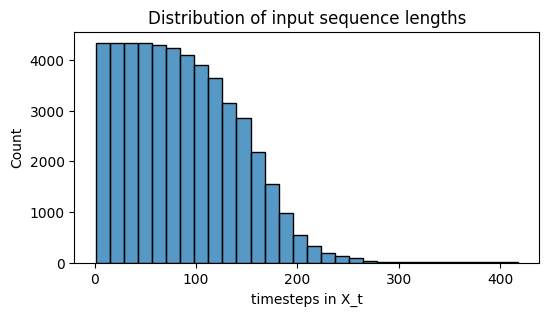

In [11]:
plt.figure(figsize=(6,3))
sns.histplot(seq_lengths, bins=30)
plt.title("Distribution of input sequence lengths")
plt.xlabel("timesteps in X_t")
plt.show()


In [12]:
X_padded = tf.keras.preprocessing.sequence.pad_sequences(
    X_seq,
    maxlen     = MAX_SEQ_LEN,
    dtype      = "float32",
    padding    = "pre",
    truncating = "pre",
)
Y_array = np.stack(Y_vec).astype("float32")

print("X_padded →", X_padded.shape)   # (N , MAX_SEQ_LEN , 46)
print("Y_array  →", Y_array.shape)    # (N , 46)


X_padded → (49674, 100, 46)
Y_array  → (49674, 46)


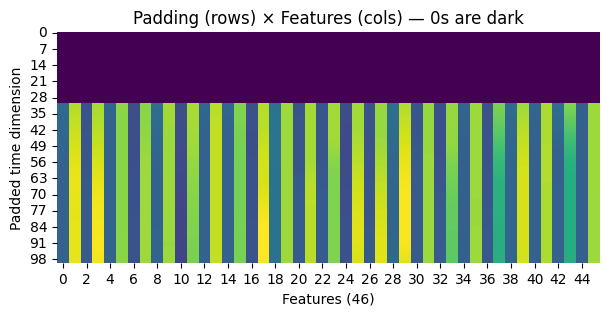

In [13]:
sample = X_padded[3000]           # choose any index
plt.figure(figsize=(7,3))
sns.heatmap(sample, cmap="viridis", cbar=False)
plt.title("Padding (rows) × Features (cols) — 0s are dark")
plt.xlabel("Features (46)")
plt.ylabel("Padded time dimension")
plt.show()


In [14]:
BATCH = 64

dataset = tf.data.Dataset.from_tensor_slices((X_padded, Y_array))\
            .shuffle(buffer_size=len(X_padded), reshuffle_each_iteration=True)\
            .batch(BATCH)\
            .prefetch(tf.data.AUTOTUNE)


In [15]:
for xb, yb in dataset.take(1):
    print("Batch X:", xb.shape)   # (BATCH , MAX_SEQ_LEN , 46)
    print("Batch Y:", yb.shape)   # (BATCH , 46)


Batch X: (64, 100, 46)
Batch Y: (64, 46)


In [16]:
NUM_ENTITIES = 23      # ← already defined above

# ── 1 · find the first sample with ≥ 3 non‑padding frames ────────────────
sample_idx = next(
    i for i, x in enumerate(X_padded)
    if (x.sum(axis=1) != 0).sum() >= 3
)

# indices of real (non‑zero) frames in that sample
real_rows = np.where(X_padded[sample_idx].sum(axis=1) != 0)[0]

print(f"Sample #{sample_idx}   –   real frames: {real_rows.tolist()}")

# ── 2 · print x,y for the first three frames ────────────────────────────
for f_idx in real_rows[:3]:
    frame = X_padded[sample_idx, f_idx]        # shape (46,)
    xs, ys = frame[::2], frame[1::2]           # split into 23 x‑coords & 23 y‑coords
    print(f"\n🖼️  Frame {f_idx}")
    for p in range(NUM_ENTITIES):
        print(f"  Player {p+1:02d}: x = {xs[p]:.3f}, y = {ys[p]:.3f}")

# ── 3 · print the Y target that corresponds to this (X, Y) pair ─────────
print("\n🎯 Target (t+1) vector:")
for p in range(NUM_ENTITIES):
    x_t1 = Y_array[sample_idx][2*p]
    y_t1 = Y_array[sample_idx][2*p + 1]
    print(f"  Player {p+1:02d}: x̂ = {x_t1:.3f}, ŷ = {y_t1:.3f}")


Sample #2   –   real frames: [97, 98, 99]

🖼️  Frame 97
  Player 01: x = 0.368, y = 0.514
  Player 02: x = 0.317, y = 0.505
  Player 03: x = 0.370, y = 0.559
  Player 04: x = 0.329, y = 0.516
  Player 05: x = 0.336, y = 0.536
  Player 06: x = 0.394, y = 0.521
  Player 07: x = 0.380, y = 0.539
  Player 08: x = 0.317, y = 0.533
  Player 09: x = 0.371, y = 0.583
  Player 10: x = 0.317, y = 0.557
  Player 11: x = 0.369, y = 0.540
  Player 12: x = 0.337, y = 0.525
  Player 13: x = 0.393, y = 0.557
  Player 14: x = 0.371, y = 0.521
  Player 15: x = 0.378, y = 0.527
  Player 16: x = 0.385, y = 0.547
  Player 17: x = 0.332, y = 0.545
  Player 18: x = 0.325, y = 0.531
  Player 19: x = 0.313, y = 0.543
  Player 20: x = 0.311, y = 0.516
  Player 21: x = 0.324, y = 0.552
  Player 22: x = 0.379, y = 0.515
  Player 23: x = 0.355, y = 0.538

🖼️  Frame 98
  Player 01: x = 0.368, y = 0.514
  Player 02: x = 0.318, y = 0.502
  Player 03: x = 0.370, y = 0.560
  Player 04: x = 0.330, y = 0.515
  Player 05:

In [17]:
# ──────────────────────────────────────────────────────────────
# 6 · Persist the dataset                                     │
# ──────────────────────────────────────────────────────────────
#
# We **save the un‑batched, un‑shuffled dataset** so that the
# file on disk is deterministic.  (You can always shuffle/batch
# again after loading.)

FOLDER = "NFL_data/"
RAW_SAVE_DIR = FOLDER + "transformer_dataset"      # any folder name you like

# ❶ strip shuffling / batching for a clean, raw save
raw_ds = tf.data.Dataset.from_tensor_slices((X_padded, Y_array))

# ❷ write to disk   (TF ≥ 2.14 uses Dataset.save; older TF → tf.data.experimental.save)
raw_ds.save(RAW_SAVE_DIR)          # creates a directory full of TFRecords

print(f"✅ Saved dataset to “{RAW_SAVE_DIR}/”")

# ──────────────────────────────────────────────────────────────
# 7 · Reload and rebuild pipeline                             │
# ──────────────────────────────────────────────────────────────
#
#   load  → shuffle → batch → prefetch
#
loaded_raw = tf.data.Dataset.load(RAW_SAVE_DIR)

BATCH  = 64
loaded_ds = loaded_raw.shuffle(4096).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# quick sanity‑check
for xb, yb in loaded_ds.take(1):
    print("Loaded batch shapes:", xb.shape, yb.shape)


✅ Saved dataset to “NFL_data/transformer_dataset/”
Loaded batch shapes: (64, 100, 46) (64, 46)
